**1. PCOS  Detection**



Get the directory structure and data from git

In [1]:
%%shell
clean_up=true
if [ "$clean_up" = true ] ; then
  echo 'doing rm -rf on the pcos and its content, fresh start!'
  rm -rf /content/pcos
fi

doing rm -rf on the pcos and its content, fresh start!


In [2]:
%%shell
if [[ -d /content/pcos ]]; then
  echo "pcos exists , will not clone from git"
else
  echo "will clone from git"
  git clone https://github.com/fidodido12/pcos.git
fi


will clone from git
Cloning into 'pcos'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 25
Receiving objects: 100% (28/28), 66.17 MiB | 41.24 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
%%shell
if [[ -d /content/pcos/data/test ]]; then
  echo "/content/pcos/data/test exists"
else
  echo "will create /content/pcos/data/test"
  echo "will create /content/pcos/data/test/infected"
  echo "will create /content/pcos/data/test/notinfected"
  echo "will unzip /content/pcos/test.zip"
  mkdir -p /content/pcos/data/test

  unzip -o /content/pcos/test.zip             -d /content/pcos/data/
  rm -rf /content/pcos/data/test/readme.txt
fi

In [4]:
%%shell
if [[ -d /content/pcos/data/train ]]; then
  echo "/content/pcos/data/train exists"
else
  echo "will create /content/pcos/data/train"
  echo "will create /content/pcos/data/train/infected"
  echo "will create /content/pcos/data/train/notinfected"
  echo "will unzip /content/pcos/img_0_4093.zip  /content/pcos/img_0_5988.zip /content/pcos/img_0_6005.zip"
  mkdir -p /content/pcos/data/train/
  mkdir -p /content/pcos/data/train/infected
  mkdir -p /content/pcos/data/train/notinfected
  unzip -o /content/pcos/infected.zip   -d /content/pcos/data/train/
  unzip -o /content/pcos/img_0_4093.zip -d /content/pcos/data/train/notinfected/
  unzip -o /content/pcos/img_0_5988.zip -d /content/pcos/data/train/notinfected/
  unzip -o /content/pcos/img_0_6005.zip -d /content/pcos/data/train/notinfected/
fi

will create /content/pcos/data/train
will create /content/pcos/data/train/infected
will create /content/pcos/data/train/notinfected
will unzip /content/pcos/img_0_4093.zip  /content/pcos/img_0_5988.zip /content/pcos/img_0_6005.zip
Archive:  /content/pcos/infected.zip
  inflating: /content/pcos/data/train/infected/img_0_1023.jpg  
  inflating: /content/pcos/data/train/infected/img_0_1033.jpg  
  inflating: /content/pcos/data/train/infected/img_0_1071.jpg  
  inflating: /content/pcos/data/train/infected/img_0_1075.jpg  
  inflating: /content/pcos/data/train/infected/img_0_1079.jpg  
  inflating: /content/pcos/data/train/infected/img_0_1083.jpg  
  inflating: /content/pcos/data/train/infected/img_0_1087.jpg  
  inflating: /content/pcos/data/train/infected/img_0_1088.jpg  
  inflating: /content/pcos/data/train/infected/img_0_1099.jpg  
  inflating: /content/pcos/data/train/infected/img_0_113.jpg  
  inflating: /content/pcos/data/train/infected/img_0_1130.jpg  
  inflating: /content/pcos/da

#### **1.1. Import Required Libraries**



In [5]:
import os
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

#### **1.2. Test-Train Data**
**Split the dataset**

**os.walk()-->**This function gives the possibility to list the contents of a directory. For example, it is used to find out which files and subdirectories are in the current directory.

In [6]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  # crawls inside folders
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ="data/train"
test_dir="data/test"
train_dir = "/content/pcos/data/test"
test_dir  = "/content/pcos/data/train"

**glob.glob()-->**It is a module that helps to list files in a specific folder in Python. Searches in subfolders.

In [7]:
#import pdb
#pdb.set_trace()
#train file image count
train_samples =get_files(train_dir)
#to get tags
num_classes=len(glob.glob(train_dir+"/*"))
#test file image count
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

2 Classes
38 Train images
1932 Test images


#### **1.3. ImageDataGenerator**

**ImageDataGenerator**,Data augmentation is used to increase the size of training set and to get more different image. Through Data augmentation we can prevent overfitting ,this refers to randomly changing the images in ways that shouldn’t impact their interpretation, such as horizontal flipping, zooming, and rotating




In [8]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
test_datagen=ImageDataGenerator(rescale=1./255)

**flow_from_directory() -->** Another method to read images into TensorFlow environment is to use the .flow_from_directory() method. flow_from_directory is an ImageDataGenerator method. The dataset is read with flow_from_directory without making any changes.

**Parameters:**
* **directory:** The path of the target directory. It must contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF formatted images found in each of the subdirectories will be included in the generator.
* **target_size:** A tuple of integers, (height, width), by default (256,256). All found images will be resized.
* **batch_size:** The size of the data chunks (default: 32).
* **shuffle:** Decides whether to shuffle data (default: True). If set to false, it sorts the data in alphanumeric order.



In [9]:
input_shape=(224,224,3)
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(224,224),batch_size=32)

Found 38 images belonging to 2 classes.
Found 1932 images belonging to 2 classes.


#### **1.4. CNN Model**

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

In [10]:
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu',name="conv2d_1"))
model.add(MaxPooling2D(pool_size=(3, 3),name="max_pooling2d_1"))
model.add(Conv2D(32, (3, 3),activation='relu',name="conv2d_2"))
model.add(MaxPooling2D(pool_size=(2, 2),name="max_pooling2d_2"))
model.add(Conv2D(64, (3, 3),activation='relu',name="conv2d_3"))
model.add(MaxPooling2D(pool_size=(2, 2),name="max_pooling2d_3"))
model.add(Flatten(name="flatten_1"))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 33, 33, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)        0

In [11]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 1932 images belonging to 2 classes.


When compiling the model, we provide **objective function (loss)**, **optimization method (adam)** and **accuracy** that we will follow.

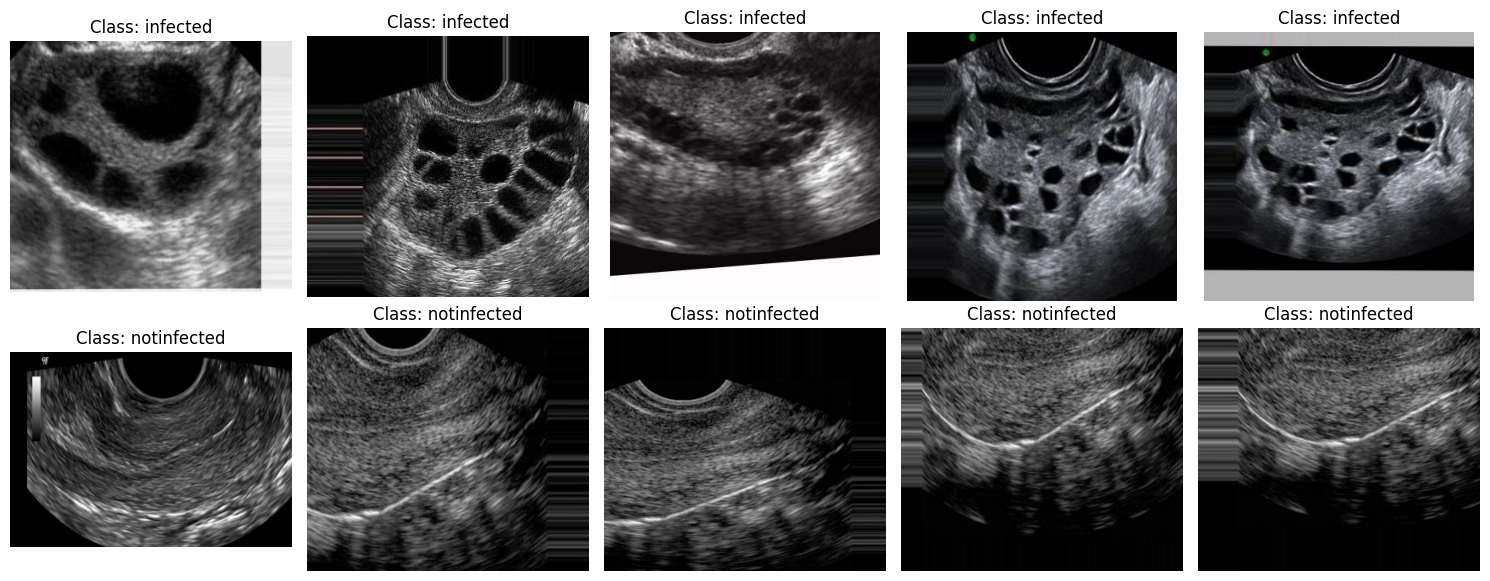

In [12]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the class labels
class_labels = sorted(os.listdir(train_dir))

# Create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

# Display 5 random images from each class
for i, class_label in enumerate(class_labels):
    class_path = os.path.join(train_dir, class_label)
    image_files = random.sample(os.listdir(class_path), 5)

    for j, image_file in enumerate(image_files):
        image_path = os.path.join(class_path, image_file)
        img = mpimg.imread(image_path)

        # Display the image in the subplot
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"Class: {class_label}")
        axes[i, j].axis('off')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


In [ ]:
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
history1 = model.fit(
    train_generator,#egitim verileri
    steps_per_epoch=None,
    epochs=8,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    shuffle=True
    )

Epoch 1/8
2/2 [==============================] - 93s 84s/step - loss: 0.6692 - accuracy: 0.4737 - val_loss: 1.3275 - val_accuracy: 0.4042 - lr: 0.0010
Epoch 2/8
2/2 [==============================] - 86s 85s/step - loss: 0.6886 - accuracy: 0.5526 - val_loss: 0.6637 - val_accuracy: 0.7391 - lr: 0.0010
Epoch 3/8
2/2 [==============================] - 57s 55s/step - loss: 0.6062 - accuracy: 0.8421 - val_loss: 0.9355 - val_accuracy: 0.4042 - lr: 0.0010
Epoch 4/8
2/2 [==============================] - 65s 65s/step - loss: 0.7315 - accuracy: 0.6316 - val_loss: 0.9761 - val_accuracy: 0.4042 - lr: 0.0010
Epoch 5/8
2/2 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.6316

In [ ]:
!mkdir /content/pcos/Model
model.save('/content/pcos/Model/PCOS_MODEL.h5')

In [ ]:
model.save('/content/pcos/Model/my_model.keras')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

print(history1.history.keys())

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()